# Importing libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.tree import export_graphviz
sns.set()

# Loading the dataset

In [4]:
current_dir = os.getcwd()
train_file_path = os.path.join(current_dir, 'CMAPSSData/train_FD001.txt')
test_file_path = os.path.join(current_dir, 'CMAPSSData/test_FD001.txt')
RUL_file_path = os.path.join(current_dir, 'CMAPSSData/RUL_FD001.txt')

In [5]:
column_names = ['unit_no', 'cycles', 'setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]

features_names = column_names + sensor_names

In [6]:
train = pd.read_csv(train_file_path, sep='\s+', header = None, names = features_names)
test = pd.read_csv(test_file_path, sep='\s+', header = None, names = features_names)
y_test = pd.read_csv(RUL_file_path, sep='\s+', header=None, names = ['RUL'])

In [7]:
sensors_to_drop = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
labels_to_drop = column_names + sensors_to_drop

# Utility functions

In [8]:
def append_rul(df):
    df_by_unit_no = df.groupby('unit_no')
    max_nb_cycles = pd.DataFrame(df_by_unit_no['cycles'].max()).rename(columns={'cycles': 'max_cycles'})
    output = df.merge(max_nb_cycles, how = 'inner', on = 'unit_no')
    output['RUL'] = output['max_cycles'] - output['cycles']
    output = output.drop(columns=['max_cycles'])
    return output

train = append_rul(train)

In [9]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_pred)
    print('RMSE : {} and R2 : {}'.format(rmse, variance))

In [10]:
def plot_learning_curves(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    train_errors, test_errors = [], []
    for m in range(500, len(X_train), 500):
        model.fit(X_train[:m], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_test_pred = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        test_errors.append(mean_squared_error(y_test, y_test_pred))
    plt.plot(np.sqrt(train_errors), label="train")
    plt.plot(np.sqrt(test_errors), label="test")
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.legend(loc="upper right", fontsize=14)
    plt.title("Learning curves")

In [11]:
X_train = train.drop(labels_to_drop, axis=1)
y_train = X_train.pop('RUL')

In [12]:
X_test = test.groupby('unit_no').last().reset_index().drop(labels_to_drop, axis=1)

# Linear regression

## All the features (except the useless ones) are considered

In [13]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [14]:
linear_reg.coef_

array([  -6.82619263,   -0.43992454,   -0.76487049,    6.89434332,
        -13.39812984,   -0.35004037,  -37.31717914,   10.64905294,
        -12.17785101,   -0.27285953, -119.91854179,   -1.85159943,
         19.92111241,   41.09981995])

In [15]:
y_pred = linear_reg.predict(X_test)

In [16]:
evaluate_model(y_test, y_pred)

RMSE : 31.952633027739893 and R2 : 0.4087736807658121


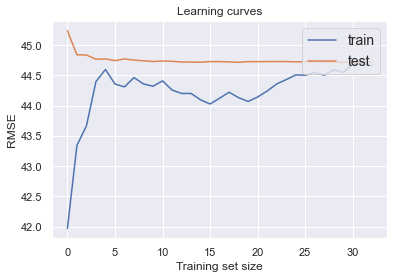

In [17]:
plot_learning_curves(linear_reg, X_train, y_train)

## Piece-wise RUL function

In [18]:
piece_wise_rul = train.loc[train['unit_no']==24].copy()
piece_wise_rul['RUL'].clip(upper=125, inplace=True)

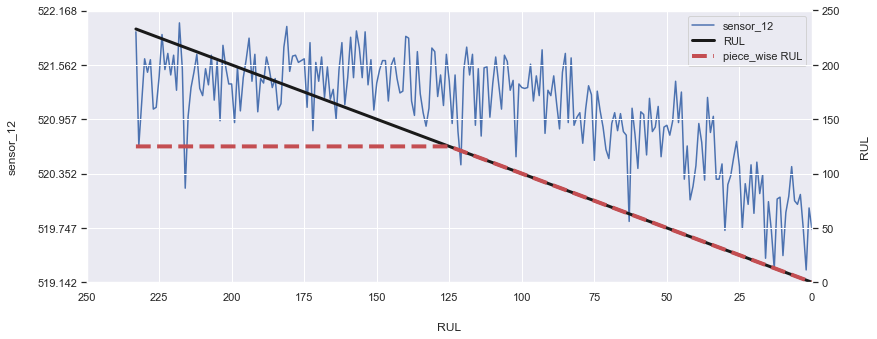

In [19]:
fig, ax1 = plt.subplots(1,1, figsize=(13,5))

signal = ax1.plot('RUL', 'sensor_12', 'b',
                 data=train.loc[train['unit_no']==20])
plt.xlim(250, 0)  
plt.xticks(np.arange(0, 275, 25))
ax1.set_ylabel('sensor_12', labelpad=20)
ax1.set_xlabel('RUL', labelpad=20)

ax2 = ax1.twinx()
rul_line = ax2.plot('RUL', 'RUL', 'k', linewidth=3,
                   data=train.loc[train['unit_no']==20])
rul = train.loc[train['unit_no']==20, 'RUL']
rul_line2 = ax2.plot(rul, rul.where(rul <= 125, 125), '--r', linewidth=4, label='piece_wise RUL') 
ax2.set_ylabel('RUL', labelpad=20)

# code to have equal spacing of y ticks for both axes, so the gridlines allign
# https://stackoverflow.com/questions/20243683/matplotlib-align-twinx-tick-marks?rq=1
ax2.set_ylim(0, 250)  # set limits of axis you want to display neatly
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))  # choose integer to neatly divide your axis, in our case 6
ax1.set_yticks(
    np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))  # apply same spacing to other axis


# code to have a unified legend
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lines = signal+rul_line+rul_line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc=0)

plt.show()

In [20]:
y_train_clipped = y_train.clip(upper=125)
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train_clipped)
y_pred = linear_reg.predict(X_test)
evaluate_model(y_test, y_pred)

RMSE : 21.900213406892572 and R2 : 0.7222608196545719


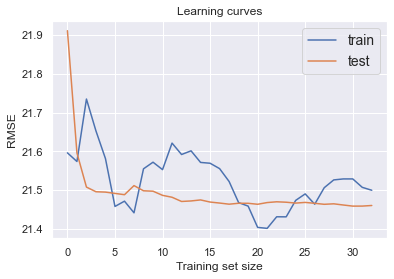

In [21]:
plot_learning_curves(linear_reg, X_train, y_train_clipped)

In [22]:
X_train.shape

(20631, 14)

## If we consider 'sensor_11', 'sensor_9' and 'sensor_4' for the moment

Only 'sensor_11'

In [23]:
linear_reg_sensor_11 = LinearRegression()
linear_reg_sensor_11.fit(X_train['sensor_11'].values.reshape(-1, 1), y_train)

y_pred = linear_reg_sensor_11.predict(X_test['sensor_11'].values.reshape(-1, 1))
evaluate_model(y_test, y_pred)

RMSE : 36.027966560183536 and R2 : 0.2483425647995059


In [24]:
lm_main_sensors = LinearRegression()
lm_main_sensors.fit(X_train[['sensor_11', 'sensor_9', 'sensor_4']], y_train)

y_pred = lm_main_sensors.predict(X_test[['sensor_11', 'sensor_9', 'sensor_4']])
evaluate_model(y_test, y_pred)

RMSE : 34.63288198768147 and R2 : 0.30542728022273824


## Ridge regression

In [25]:
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

Ridge(alpha=0.1)

In [26]:
y_pred = ridge_model.predict(X_test)
evaluate_model(y_test, y_pred)

RMSE : 31.953934740669375 and R2 : 0.408725508045913


In [27]:
ridge_model = Ridge(alpha=0.01)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
evaluate_model(y_test, y_pred)

RMSE : 31.952762299568914 and R2 : 0.40876889686821005


In [28]:
ridge_model = Ridge(alpha=0.01)
ridge_model.fit(X_train, y_train_clipped)
y_pred = ridge_model.predict(X_test)
evaluate_model(y_test, y_pred)

RMSE : 21.900034096369197 and R2 : 0.7222653676791035


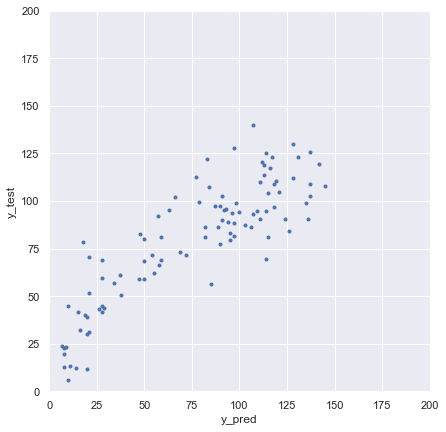

In [29]:
fig, ax = plt.subplots(figsize=(7, 7))


ax.plot(y_test, y_pred, '.')
plt.ylabel('y_test')
plt.xlabel('y_pred')
plt.axis('equal')
plt.ylim(0, 200)
plt.xlim(0, 200)
ax.set_aspect('equal', adjustable='box')

## ElasticNet

In [30]:
elasticnet_model = ElasticNet()
elasticnet_model.fit(X_train, y_train)
y_pred = elasticnet_model.predict(X_test)
evaluate_model(y_test, y_pred)

RMSE : 34.97099029285831 and R2 : 0.2917993564405843


In [31]:
elasticnet_model = ElasticNetCV()
elasticnet_model.fit(X_train, y_train)
y_pred = elasticnet_model.predict(X_test)
evaluate_model(y_test, y_pred)

RMSE : 35.10855981374478 and R2 : 0.2862165318126536


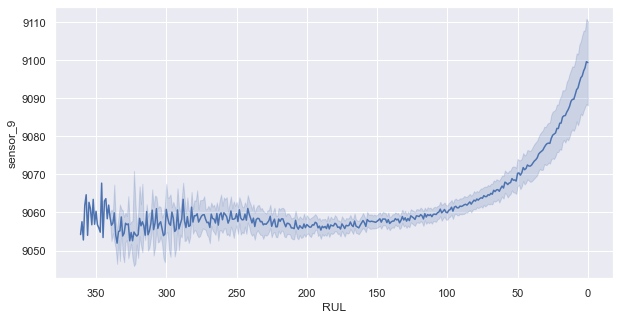

In [32]:
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data = train, x = 'RUL', y = 'sensor_9')
ax.invert_xaxis()

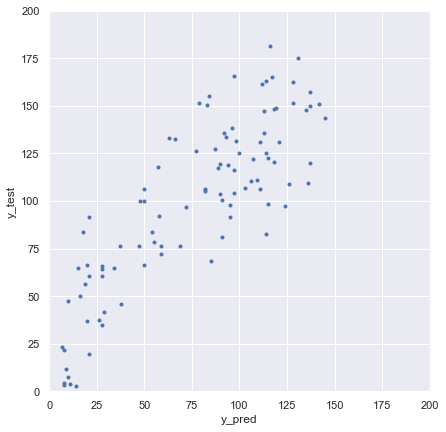

In [33]:
fig, ax = plt.subplots(figsize=(7, 7))


ax.plot(y_test, y_pred, '.')
plt.ylabel('y_test')
plt.xlabel('y_pred')
plt.axis('equal')
plt.ylim(0, 200)
plt.xlim(0, 200)
ax.set_aspect('equal', adjustable='box')

## Support vector regression

### Simple SVM model

In [34]:
scaler = MinMaxScaler()
# scaler = StandardScaler()  # for this specific dataset, the type of scaler does not have any effect
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
svm_model = SVR(kernel='linear')
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred)

RMSE : 26.225204844522736 and R2 : 0.6017294130737034


### SVM with slack 

In [36]:
svm_model = SVR(kernel='linear', epsilon=20)
svm_model.fit(X_train_scaled, y_train_clipped)
y_pred = svm_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred)

RMSE : 21.982499487932984 and R2 : 0.7201697894635622


In [37]:
# plot_learning_curves(svm_model, X_train, y_train_clipped)

In [38]:
# def svr_results(y_test, X_test, fitted_svr_model):
    
#     print("C: {}".format(fitted_svr_model.C))
#     print("Epsilon: {}".format(fitted_svr_model.epsilon))
    
#     print("Intercept: {:,.3f}".format(fitted_svr_model.intercept_[0]))
#     print("Coefficient: {:,.3f}".format(fitted_svr_model.coef_[0][0]))
    
#     mae = mean_absolute_error(y_test, fitted_svr_model.predict(X_test_scaled))
#     print("MAE = {:.2f}".format(mae))
    
#     perc_within_eps = 100*np.sum(y_test.values - fitted_svr_model.predict(X_test_scaled) < eps) / len(y_test)
#     print("Percentage within Epsilon = {:.2f}%".format(perc_within_eps))
    
#     # Plot outputs
#     plt.figure(figsize=(10,7))
#     plt.scatter(x=train['sensor_12'], y=train['RUL'])
#     plt.plot(X_test, fitted_svr_model.predict(X_test), color='red')
#     plt.plot(X_test, fitted_svr_model.predict(X_test)+eps, color='black')
#     plt.plot(X_test, fitted_svr_model.predict(X_test)-eps, color='black')
#     plt.xlabel('sensor_12')
#     plt.ylabel('RUL')
#     plt.title('SVR Prediction')
#     plt.show()

In [39]:
# train_errors, test_errors = [], []
# model = SVR(kernel='linear')
# for m in range(1000, len(X_train)):
#     model.fit(X_train[:m], y_train[:m])
#     y_train_pred = model.predict(X_train[:m])
#     y_test_pred = model.predict(X_test)
#     train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
#     test_errors.append(mean_squared_error(y_test, y_test_pred))
# plt.plot(np.sqrt(train_errors), label="train")
# plt.plot(np.sqrt(test_errors), label="test")
# plt.xlabel("Training set size")
# plt.ylabel("MSE")
# plt.legend(loc="upper right", fontsize=14)
# plt.title("Learning curves")

### RandomForest Regressor

In [40]:
#random forest regressor
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=23)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_pred_train = rf.predict(X_train)
evaluate_model(y_train_clipped, y_pred_train)

y_pred_test = rf.predict(X_test)
evaluate_model(y_test, y_pred_test)

RMSE : 6.769845141706938 and R2 : 0.973609086586133
RMSE : 18.05586433821433 and R2 : 0.8112108540216354


In [41]:
# constrained random forest
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=23, 
                           max_depth=8, min_samples_leaf=50)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_pred_train = rf.predict(X_train)
evaluate_model(y_train_clipped, y_pred_train)

y_pred_test = rf.predict(X_test)
evaluate_model(y_test, y_pred_test)

RMSE : 17.815621602789772 and R2 : 0.817232524687878
RMSE : 18.2020226288928 and R2 : 0.8081420694517261


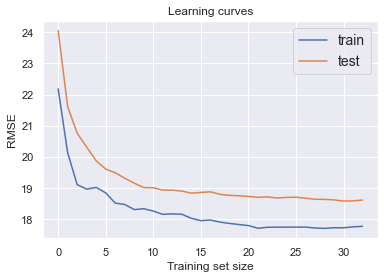

In [42]:
plot_learning_curves(rf, X_train, y_train_clipped)

### K Nearest neighbors

In [44]:
# KNN regression
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train_clipped)

y_train_pred = knn_reg.predict(X_train)
y_test_pred = knn_reg.predict(X_test)

# Prediction and evaluation 
print('Train set')
evaluate_model(y_train_clipped, y_train_pred)

print('Test set')
evaluate_model(y_test, y_test_pred)

Train set
RMSE : 18.12939954108852 and R2 : 0.8107378395480288
Test set
RMSE : 22.465137435591174 and R2 : 0.7077472439146534


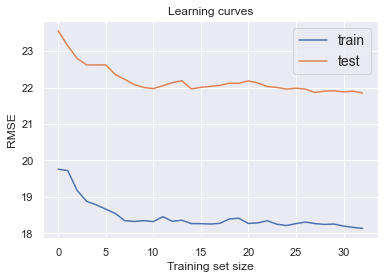

In [45]:
plot_learning_curves(knn_reg, X_train, y_train_clipped)

In [3]:
import pandoc

pandoc 